# Demo - Time Series Forecasting with TabPFN  🎉

Welcome to the demo of TabPFN for time series forecasting!

In this demo, we will show you how to use TabPFN for time series forecasting. Concretely, we will:

1. **Load time series data** -- you can also bring in time series data from your own problem
2. **Add features** -- we will use default features, but feel free to experiment with your own features!
3. **Perform prediction** -- zero-shot! 😉
4. **Visualize the forecasting results**


## Setup

In [ ]:
# !pip install tabpfn-time-series>=1.0.0

## Load Time Series Data

In this demo, we will use the time series dataset from [Chronos Dataset](https://huggingface.co/datasets/autogluon/chronos_datasets) on HuggingFace. Also, we'll keep it short and work with just 2 time series from the dataset.

Feel free to explore other datasets by using the dataset names from Chronos Dataset on HuggingFace or even use time series data of your own problem.

In [1]:
dataset_metadata = {
    "monash_tourism_monthly": {"prediction_length": 24},
    "m4_hourly": {"prediction_length": 48},
}

dataset_choice = "monash_tourism_monthly"
num_time_series_subset = 2

In [2]:
from datasets import load_dataset
from autogluon.timeseries import TimeSeriesDataFrame

from tabpfn_time_series.data_preparation import to_gluonts_univariate, generate_test_X

prediction_length = dataset_metadata[dataset_choice]["prediction_length"]
dataset = load_dataset("autogluon/chronos_datasets", dataset_choice)

tsdf = TimeSeriesDataFrame(to_gluonts_univariate(dataset["train"]))
tsdf = tsdf[
    tsdf.index.get_level_values("item_id").isin(tsdf.item_ids[:num_time_series_subset])
]
train_tsdf, test_tsdf_ground_truth = tsdf.train_test_split(
    prediction_length=prediction_length
)
test_tsdf = generate_test_X(train_tsdf, prediction_length)

Let's take a look at the time series data.

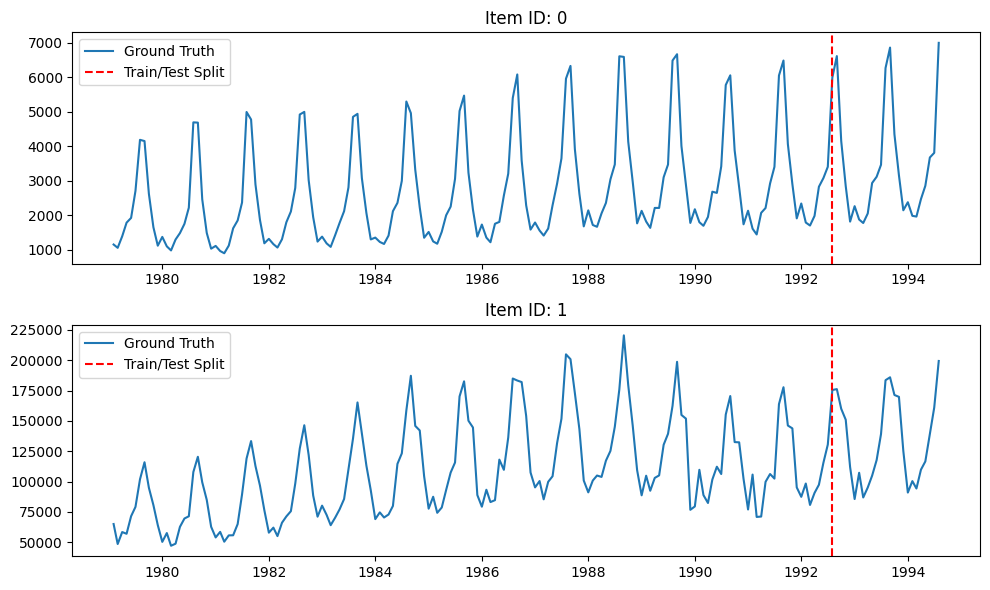

In [3]:
from tabpfn_time_series.plot import plot_actual_ts

plot_actual_ts(train_tsdf, test_tsdf_ground_truth)

## Adding Features

In our paper, we propose adding `Running Index`, `Calendar Features`, and `Auto Seasonal Features` to the table.

**Feel free to experiment with your own features!**

To do that, simply define your own feature functions and pass them to the `FeatureTransformer`.

In [4]:
from tabpfn_time_series import FeatureTransformer
from tabpfn_time_series.features import (
    RunningIndexFeature,
    CalendarFeature,
    AutoSeasonalFeature,
)

selected_features = [
    RunningIndexFeature(),
    CalendarFeature(),
    AutoSeasonalFeature(),
]

feature_transformer = FeatureTransformer(selected_features)

train_tsdf, test_tsdf = feature_transformer.transform(train_tsdf, test_tsdf)

Let's take a look at the tables (train and test) before we proceed to do predictions.

✅ Realize that we have added some features into the tables.

In [5]:
train_tsdf.head()

target  running_index  year  second_of_minute_sin  \
item_id timestamp                                                          
0       1979-01-31  1149.8700              0  1979                   0.0   
        1979-02-28  1053.8002              1  1979                   0.0   
        1979-03-31  1388.8798              2  1979                   0.0   
        1979-04-30  1783.3702              3  1979                   0.0   
        1979-05-31  1921.0252              4  1979                   0.0   

                    second_of_minute_cos  minute_of_hour_sin  \
item_id timestamp                                              
0       1979-01-31                   1.0                 0.0   
        1979-02-28                   1.0                 0.0   
        1979-03-31                   1.0                 0.0   
        1979-04-30                   1.0                 0.0   
        1979-05-31                   1.0                 0.0   

                    minute_of_hour_cos  hour_of_day_sin  hour_of_day_cos  \
item_id timestamp                                                          
0       1979-01-31                 1.0              0.0              1.0   
        1979-02-28                 1.0              0.0              1.0   
        1979-03-31                 1.0              0.0              1.0   
        1979-04-30                 1.0              0.0              1.0   
        1979-05-31                 1.0              0.0              1.0   

                    day_of_week_sin  ...    sin_#0        cos_#0  \
item_id timestamp                    ...                           
0       1979-01-31     8.660254e-01  ...  0.000000  1.000000e+00   
        1979-02-28     8.660254e-01  ...  0.500000  8.660254e-01   
        1979-03-31    -8.660254e-01  ...  0.866025  5.000000e-01   
        1979-04-30     0.000000e+00  ...  1.000000  6.123234e-17   
        1979-05-31     1.224647e-16  ...  0.866025 -5.000000e-01   

                          sin_#1  cos_#1        sin_#2        cos_#2  \
item_id timestamp                                                      
0       1979-01-31  0.000000e+00     1.0  0.000000e+00  1.000000e+00   
        1979-02-28  8.660254e-01     0.5  1.000000e+00  6.123234e-17   
        1979-03-31  8.660254e-01    -0.5  1.224647e-16 -1.000000e+00   
        1979-04-30  1.224647e-16    -1.0 -1.000000e+00 -1.836970e-16   
        1979-05-31 -8.660254e-01    -0.5 -2.449294e-16  1.000000e+00   

                          sin_#3  cos_#3        sin_#4  cos_#4  
item_id timestamp                                               
0       1979-01-31  0.000000e+00     1.0  0.000000e+00     1.0  
        1979-02-28  1.224647e-16    -1.0  8.660254e-01    -0.5  
        1979-03-31 -2.449294e-16     1.0 -8.660254e-01    -0.5  
        1979-04-30  3.673940e-16    -1.0 -2.449294e-16     1.0  
        1979-05-31 -4.898587e-16     1.0  8.660254e-01    -0.5  

[5 rows x 29 columns]

In [6]:
test_tsdf.head()

target  running_index  year  second_of_minute_sin  \
item_id timestamp                                                       
0       1992-08-31     NaN            163  1992                   0.0   
        1992-09-30     NaN            164  1992                   0.0   
        1992-10-31     NaN            165  1992                   0.0   
        1992-11-30     NaN            166  1992                   0.0   
        1992-12-31     NaN            167  1992                   0.0   

                    second_of_minute_cos  minute_of_hour_sin  \
item_id timestamp                                              
0       1992-08-31                   1.0                 0.0   
        1992-09-30                   1.0                 0.0   
        1992-10-31                   1.0                 0.0   
        1992-11-30                   1.0                 0.0   
        1992-12-31                   1.0                 0.0   

                    minute_of_hour_cos  hour_of_day_sin  hour_of_day_cos  \
item_id timestamp                                                          
0       1992-08-31                 1.0              0.0              1.0   
        1992-09-30                 1.0              0.0              1.0   
        1992-10-31                 1.0              0.0              1.0   
        1992-11-30                 1.0              0.0              1.0   
        1992-12-31                 1.0              0.0              1.0   

                    day_of_week_sin  ...    sin_#0        cos_#0  \
item_id timestamp                    ...                           
0       1992-08-31     0.000000e+00  ... -0.500000 -8.660254e-01   
        1992-09-30     8.660254e-01  ... -0.866025 -5.000000e-01   
        1992-10-31    -8.660254e-01  ... -1.000000 -1.224956e-14   
        1992-11-30     0.000000e+00  ... -0.866025  5.000000e-01   
        1992-12-31     1.224647e-16  ... -0.500000  8.660254e-01   

                          sin_#1  cos_#1        sin_#2        cos_#2  \
item_id timestamp                                                      
0       1992-08-31  8.660254e-01     0.5 -1.000000e+00 -2.596808e-14   
        1992-09-30  8.660254e-01    -0.5 -3.135839e-14  1.000000e+00   
        1992-10-31  2.449913e-14    -1.0  1.000000e+00  3.674869e-14   
        1992-11-30 -8.660254e-01    -0.5 -1.470443e-14 -1.000000e+00   
        1992-12-31 -8.660254e-01     0.5 -1.000000e+00  9.314124e-15   

                          sin_#3  cos_#3        sin_#4  cos_#4  
item_id timestamp                                               
0       1992-08-31  5.193617e-14    -1.0  8.660254e-01    -0.5  
        1992-09-30 -6.271677e-14     1.0 -8.660254e-01    -0.5  
        1992-10-31  7.349738e-14    -1.0 -4.899825e-14     1.0  
        1992-11-30  2.940885e-14     1.0  8.660254e-01    -0.5  
        1992-12-31 -1.862825e-14    -1.0 -8.660254e-01    -0.5  

[5 rows x 29 columns]

## Prediction

Now, let's perform prediction.

We provide two options, `TabPFNMode.LOCAL` and `TabPFNMode.CLIENT`, as the backend for TabPFN.

- `TabPFNMode.LOCAL` uses your local machine to run TabPFN.
- `TabPFNMode.CLIENT` uses TabPFN's inference service provided by [tabpfn-client](https://github.com/automl/tabpfn-client)

For this demo, we'll use `TabPFNMode.CLIENT` to perform prediction. If you have not use the client before, you'll be prompted to create an account.

Note: if your machine doesn't have a GPU, using `TabPFNMode.CLIENT` is recommended -- must faster 😉.


In [ ]:
from tabpfn_time_series import TabPFNTimeSeriesPredictor, TabPFNMode

predictor = TabPFNTimeSeriesPredictor(
    tabpfn_mode=TabPFNMode.CLIENT,
)

pred = predictor.predict(train_tsdf, test_tsdf)

## Visualize the Results

Let's visualize the forecasting results.

Also, note that we provide both **point prediction** and **quantile prediction**, how amazing! 😄

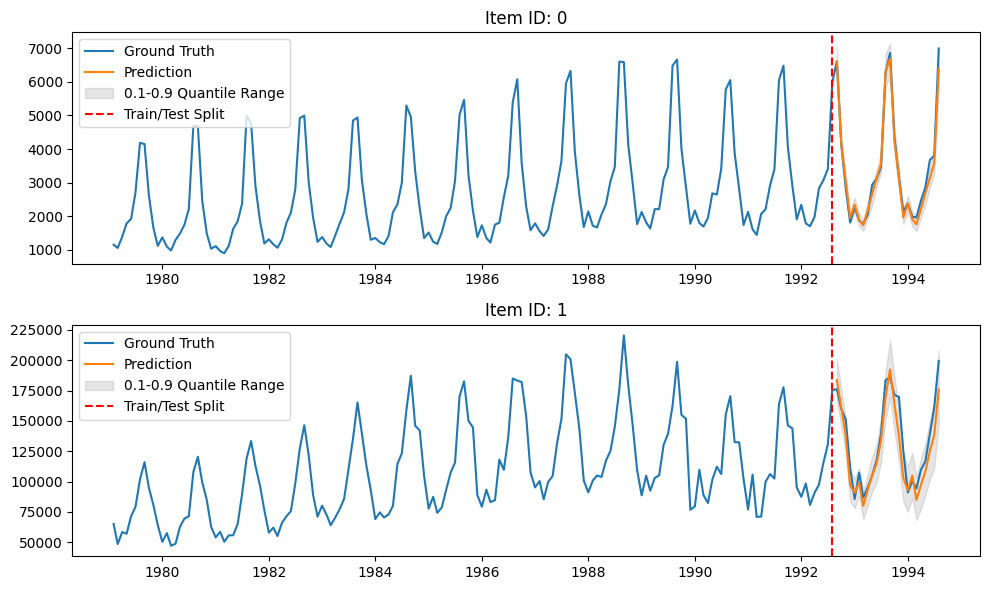

In [8]:
from tabpfn_time_series.plot import plot_pred_and_actual_ts

plot_pred_and_actual_ts(
    train=train_tsdf,
    test=test_tsdf_ground_truth,
    pred=pred,
)

In [9]:
pred.head()

target          0.1          0.2          0.3  \
item_id timestamp                                                        
0       1992-08-31  6609.700684  6202.674316  6350.402344  6454.662109   
        1992-09-30  4170.768555  3892.191895  3991.002686  4059.480957   
        1992-10-31  3030.181885  2810.128906  2885.848633  2942.313477   
        1992-11-30  1946.637817  1767.867920  1829.571289  1872.797729   
        1992-12-31  2347.503906  2110.860352  2195.830811  2254.408203   

                            0.4          0.5          0.6          0.7  \
item_id timestamp                                                        
0       1992-08-31  6537.622070  6609.700684  6689.758789  6773.496094   
        1992-09-30  4117.242188  4170.768555  4223.979492  4281.280273   
        1992-10-31  2986.870605  3030.181885  3072.674805  3120.361328   
        1992-11-30  1911.092651  1946.637817  1983.111084  2022.806763   
        1992-12-31  2301.853760  2347.503906  2390.907959  2435.843018   

                            0.8          0.9  
item_id timestamp                             
0       1992-08-31  6878.810059  7046.443359  
        1992-09-30  4353.340332  4463.009766  
        1992-10-31  3175.226074  3260.745117  
        1992-11-30  2071.988770  2144.815674  
        1992-12-31  2487.239014  2556.109131

# Feedback

Let us know what you think!

Write us at Discord: https://discord.gg/qK7AaXPN or just simply create an issue on [GitHub](https://github.com/liam-sbhoo/tabpfn-time-series/tree/main).

Thank you for trying out our method! 🎉
